# Sestavování matic tuhosti

FEniCS je knihovna s vysokým stupněm abstrakce a tedy umožňuje jako vstup zadat slabou formu, kterou následně vyřeší. Technikality jako je sestavování matice tuhosti a řešení soustavy rovnic s řídkou maticí pak řeší knihovna za nás bez nutnosti do tohoto procesu zasahovat. Občas se ale hodí zasahovat i do těchto pater výpočtu a proto je v tomto krátkém kódu představeno, jakým způsobem vytáhnout matici soustavy, která reprezentuje náš fyzikální problém. Námi představená funkce poté vykreslí diagram zaplněnosi matic, kdy černá políčka reprezentují nenulový prvek a bílá políčka prvky matice, které jsou obsazeny nulou.

In [1]:
from mpi4py import MPI
import dolfinx as dfx
import numpy as np
import ufl
from dolfinx import default_scalar_type
import matplotlib.pyplot as plt
import pyvista


def plot_and_print_matrices(mx, type):
    # --------------------
    # Geometry
    # --------------------
    if type == "int":
        domain = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, mx)
    elif type == "rect":
        domain = dfx.mesh.create_unit_square(MPI.COMM_WORLD, mx, mx, dfx.mesh.CellType.quadrilateral)
    else:
        domain = dfx.mesh.create_unit_square(MPI.COMM_WORLD, mx, mx, dfx.mesh.CellType.triangle)
    tdim = domain.topology.dim
    fdim = tdim - 1
        
    #print("Mesh:")
    #import pyvista
    #if pyvista.OFF_SCREEN:
    #    pyvista.start_xvfb()
    #topology, cell_types, geometry = dfx.plot.vtk_mesh(domain, tdim)
    #grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

    #plotter = pyvista.Plotter()
    #plotter.add_mesh(grid, show_edges=True)
    #plotter.view_xy()
    #if not pyvista.OFF_SCREEN:
    #    plotter.show()
    #else:
    #    plotter.show()

    # --------------------
    # Function spaces
    # --------------------
    V = dfx.fem.FunctionSpace(domain, ("Lagrange", 1))

    # --------------------
    # Boundary conditions
    # --------------------
    uD = dfx.fem.Function(V)
    uD.interpolate(lambda x: 1000 + 0*x[0])
    # Create facet to cell connectivity required to determine boundary facets
    domain.topology.create_connectivity(fdim, tdim)
    boundary_facets = dfx.mesh.exterior_facet_indices(domain.topology)
    boundary_dofs = dfx.fem.locate_dofs_topological(V, fdim, boundary_facets)
    bc = dfx.fem.dirichletbc(uD, boundary_dofs)

    # --------------------
    # Weak form
    # --------------------
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx

    # --------------------
    # Matrices
    # --------------------
    a_matrix = dfx.fem.assemble_matrix(dfx.fem.form(a))

    # Printing matrices
    print("A matrix:\n", np.array_str(a_matrix.to_dense(), precision=3))

    # Plotting matrices
    #matrix = a_matrix.to_scipy().toarray()
    matrix = a_matrix.to_dense()
    m_inv = np.linalg.inv(matrix[1:, 1:])

    # Printing matrices
    print("A inverse:\n", np.array_str(m_inv, precision=3))
    plt.spy(matrix)
    plt.title("Obsazenost matice A")
    plt.show()
    plt.spy(m_inv)
    plt.title("Obsazenost matice A_inv")
    plt.show()

Naše metoda pro zajímavost spočte i inverzní matici klasickou eliminací a i plnost této matice je vykreslena. Dále je tato metoda spuštěna pro různé typy prvků a různou velikost výpočetní sítě.

A matrix:
 [[ 2. -2.  0.]
 [-2.  4. -2.]
 [ 0. -2.  2.]]
A inverse:
 [[0.5 0.5]
 [0.5 1. ]]


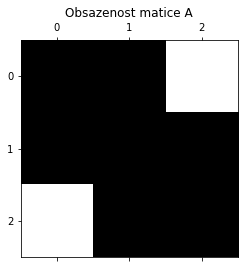

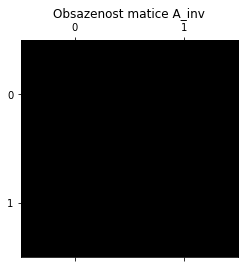

In [2]:
plot_and_print_matrices(2, "int")

A matrix:
 [[ 10. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.  20. -10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -10.  20. -10.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -10.  20. -10.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -10.  20. -10.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -10.  20. -10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -10.  20. -10.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -10.  20. -10.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -10.  20. -10.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -10.  20. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -10.  10.]]
A inverse:
 [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.1 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3]
 [0.1 0.2 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.1 0.2 0.3 0.4 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.1 0.2 0.3 0.4 0.5 0.6 0.6 0.6 0.6 0.6]
 [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.7 0.7 0.7]
 [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.8

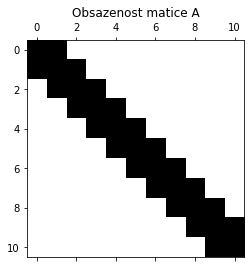

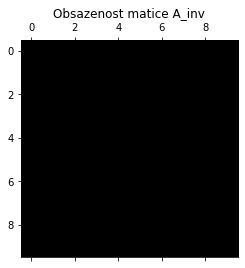

In [3]:
plot_and_print_matrices(10, "int")

A matrix:
 [[ 100. -100.    0. ...    0.    0.    0.]
 [-100.  200. -100. ...    0.    0.    0.]
 [   0. -100.  200. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...  200. -100.    0.]
 [   0.    0.    0. ... -100.  200. -100.]
 [   0.    0.    0. ...    0. -100.  100.]]
A inverse:
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.02 0.02 ... 0.02 0.02 0.02]
 [0.01 0.02 0.03 ... 0.03 0.03 0.03]
 ...
 [0.01 0.02 0.03 ... 0.98 0.98 0.98]
 [0.01 0.02 0.03 ... 0.98 0.99 0.99]
 [0.01 0.02 0.03 ... 0.98 0.99 1.  ]]


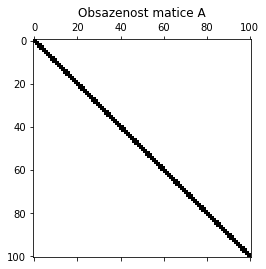

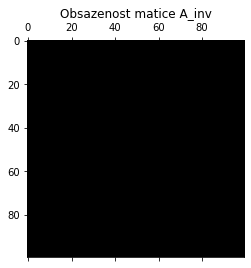

In [4]:
plot_and_print_matrices(100, "int")

A matrix:
 [[ 0.667 -0.167 -0.167 -0.333  0.     0.     0.     0.     0.   ]
 [-0.167  1.333 -0.333 -0.333 -0.167 -0.333  0.     0.     0.   ]
 [-0.167 -0.333  1.333 -0.333  0.     0.    -0.167 -0.333  0.   ]
 [-0.333 -0.333 -0.333  2.667 -0.333 -0.333 -0.333 -0.333 -0.333]
 [ 0.    -0.167  0.    -0.333  0.667 -0.167  0.     0.     0.   ]
 [ 0.    -0.333  0.    -0.333 -0.167  1.333  0.    -0.333 -0.167]
 [ 0.     0.    -0.167 -0.333  0.     0.     0.667 -0.167  0.   ]
 [ 0.     0.    -0.333 -0.333  0.    -0.333 -0.167  1.333 -0.167]
 [ 0.     0.     0.    -0.333  0.    -0.167  0.    -0.167  0.667]]
A inverse:
 [[2.    1.35  1.325 1.55  1.55  1.35  1.4   1.4  ]
 [1.35  2.    1.325 1.35  1.4   1.55  1.55  1.4  ]
 [1.325 1.325 1.675 1.55  1.525 1.55  1.525 1.6  ]
 [1.55  1.35  1.55  3.1   1.75  1.5   1.55  1.6  ]
 [1.55  1.4   1.525 1.75  2.4   1.55  1.75  1.8  ]
 [1.35  1.55  1.55  1.5   1.55  3.1   1.75  1.6  ]
 [1.4   1.55  1.525 1.55  1.75  1.75  2.4   1.8  ]
 [1.4   1.4   1.6   1.6  

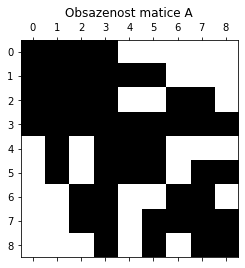

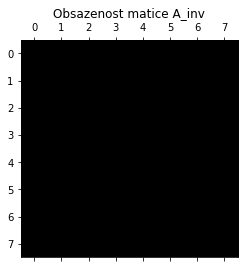

In [5]:
plot_and_print_matrices(2, "rect")

A matrix:
 [[ 0.667 -0.167 -0.167 ...  0.     0.     0.   ]
 [-0.167  1.333 -0.333 ...  0.     0.     0.   ]
 [-0.167 -0.333  1.333 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  1.333 -0.333 -0.167]
 [ 0.     0.     0.    ... -0.333  1.333 -0.167]
 [ 0.     0.     0.    ... -0.167 -0.167  0.667]]
A inverse:
 [[1.989 1.356 1.327 ... 1.452 1.452 1.452]
 [1.356 1.989 1.327 ... 1.452 1.452 1.452]
 [1.327 1.327 1.673 ... 1.548 1.548 1.548]
 ...
 [1.452 1.452 1.548 ... 4.427 3.795 3.89 ]
 [1.452 1.452 1.548 ... 3.795 4.427 3.89 ]
 [1.452 1.452 1.548 ... 3.89  3.89  5.342]]


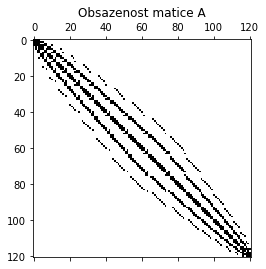

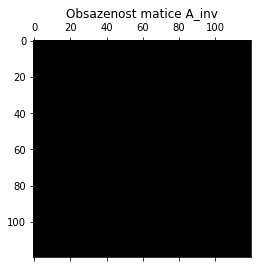

In [6]:
plot_and_print_matrices(10, "rect")

A matrix:
 [[ 2.  -0.5  0.  -1.  -0.5  0.   0.   0.   0. ]
 [-0.5  1.  -0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  2.  -1.   0.  -0.5  0.   0.   0. ]
 [-1.   0.  -1.   4.   0.   0.  -1.  -1.   0. ]
 [-0.5  0.   0.   0.   1.   0.  -0.5  0.   0. ]
 [ 0.   0.  -0.5  0.   0.   1.   0.  -0.5  0. ]
 [ 0.   0.   0.  -1.  -0.5  0.   2.   0.  -0.5]
 [ 0.   0.   0.  -1.   0.  -0.5  0.   2.  -0.5]
 [ 0.   0.   0.   0.   0.   0.  -0.5 -0.5  1. ]]
A inverse:
 [[1.292 0.583 0.292 0.125 0.458 0.25  0.333 0.292]
 [0.583 1.167 0.583 0.25  0.917 0.5   0.667 0.583]
 [0.292 0.583 0.708 0.292 0.625 0.583 0.667 0.625]
 [0.125 0.25  0.292 1.292 0.292 0.583 0.333 0.458]
 [0.458 0.917 0.625 0.292 1.958 0.583 1.    0.792]
 [0.25  0.5   0.583 0.583 0.583 1.167 0.667 0.917]
 [0.333 0.667 0.667 0.333 1.    0.667 1.333 1.   ]
 [0.292 0.583 0.625 0.458 0.792 0.917 1.    1.958]]


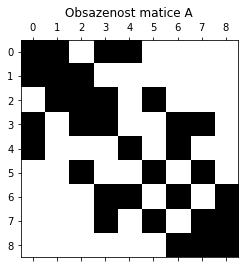

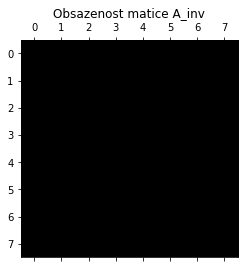

In [7]:
plot_and_print_matrices(2, "tri")

A matrix:
 [[ 2.  -0.5  0.  ...  0.   0.   0. ]
 [-0.5  1.  -0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  2.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.   0.  -0.5]
 [ 0.   0.   0.  ...  0.   2.  -0.5]
 [ 0.   0.   0.  ... -0.5 -0.5  1. ]]
A inverse:
 [[1.273 0.547 0.273 ... 0.273 0.273 0.273]
 [0.547 1.093 0.547 ... 0.546 0.547 0.547]
 [0.273 0.547 0.669 ... 0.547 0.547 0.547]
 ...
 [0.273 0.546 0.547 ... 3.195 2.648 2.922]
 [0.273 0.547 0.547 ... 2.648 3.195 2.922]
 [0.273 0.547 0.547 ... 2.922 2.922 3.922]]


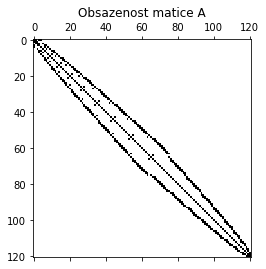

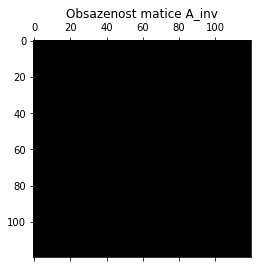

In [8]:
plot_and_print_matrices(10, "tri")